In [119]:
# about torch
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

# using numpy
import numpy as np

# for data load or save
import pandas as pd

# visualize some datasets
import matplotlib.pyplot as plt

# check our work directory
import os

# to unzip datasets
import zipfile

### 1.3 2. Hyper parameters Setting

In [120]:
lr = 0.001  # learning_rate
batch_size = 100 # we will use mini_batch method
epochs = 10 # How much to train a model

3. Set seed and Random Value

In [121]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(1234)
if device == "cuda":
    torch.cuda.manual_seed_all(1234)

1.4 4. Load train, test data

In this competition, we can not use datasets with only pandas we should to unzip dataset.and we must check our working directory before unzipping

check a directory

In [122]:
os.listdir("../input/dogs-vs-cats-redux-kernels-edition")

['test.zip', 'train.zip']

#### 1.4.1 mske a directory for our datasets after unzipping

In [123]:
os.makedirs("../data", exist_ok=True)

In [124]:
base_dir = "../input/dogs-vs-cats-redux-kernels-edition"
train_dir = "../data/train"
test_dir = "../data/test"

In [125]:
with zipfile.ZipFile(os.path.join(base_dir, "train.zip")) as train_zip:
    train_zip.extractall("../data")
with zipfile.ZipFile(os.path.join(base_dir, "test.zip")) as test_zip:
    test_zip.extractall("../data")

In [126]:
os.listdir(train_dir)[: 5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

In [127]:
import glob

# 获取所有照片的文件名
train_list = glob.glob(os.path.join(train_dir, "*.jpg"))
test_list = glob.glob(os.path.join(test_dir, "*.jpg"))

In [128]:
len(train_list)

25000

#### 1.4.2 check our datasets

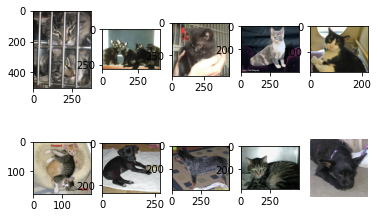

In [129]:
from PIL import Image
random_idx = np.random.randint(1, 25000, size=10)

fig = plt.figure()
i = 1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i += 1
    
plt.axis("off")
plt.show()

In [130]:
train_list[0].split("\\")[-1].split(".")[0]  

'cat'

In [131]:
int(test_list[0].split('\\')[-1].split('.')[0])

1

In [132]:
print(len(train_list), len(test_list))

25000 12500


In [133]:
from sklearn.model_selection import train_test_split  
# 将数据集随机分成训练集和验证集
train_list, val_list = train_test_split(train_list, test_size=0.2)

## 1.5 Image Augumentation
    we have to do this job before making our model.cuz it will prevent overfitting Possibility

In [134]:
# data Augumentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

## Load datasets
    this code is for load our image sets. you can find this code easily in pytorch.org main page

In [135]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        
    # dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    # load an one of images
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split("\\")[-1].split(".")[0]
        if label == "dog":
            label = 1
        elif label == "cat":
            label = 0
        return img_transformed, label

## 1.6.1 use torchvision.datasets

In [136]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [137]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [138]:
print(len(train_loader))

200


In [139]:
print(len(train_data), len(train_loader))

20000 200


In [140]:
# check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

## 1.7 build Model
    3 Convolution layer and 2 fully connected layer
    batchNormalization for limit overfitting

In [141]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(3*3*64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [142]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

### 1.8 set Loss function and optimizer

In [143]:
optimizer = optim.Adam(params = model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### 1.9 Train out Network

In [144]:
from tqdm import tqdm 
epochs = 50

for epoch in range(epochs):
    epoch_loss = 0 
    epoch_accuracy = 0
    
    for data, label in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}",
                               ascii=True, total=len(train_loader)):
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1)==label).float().mean()) #???   #  output.argmax(dim=1) dim=1 每一行的最大列标号
        """  调试过程
        print(output)
        print(output.shape)
        print(output.argmax(dim=1))"""
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    
    print("Epoch: {}, train accuracy: {}, train loss : {}".format(epoch+1, epoch_accuracy, epoch_loss))
    
        

Epoch 0/50: 100%|####################################################################| 200/200 [01:28<00:00,  2.25it/s]


Epoch: 1, train accuracy: 0.6467502117156982, train loss : 0.624973714351654


Epoch 1/50: 100%|####################################################################| 200/200 [01:21<00:00,  2.46it/s]


Epoch: 2, train accuracy: 0.695349931716919, train loss : 0.5754775404930115


Epoch 2/50: 100%|####################################################################| 200/200 [01:23<00:00,  2.38it/s]


Epoch: 3, train accuracy: 0.713949978351593, train loss : 0.5482386350631714


Epoch 3/50: 100%|####################################################################| 200/200 [01:22<00:00,  2.43it/s]


Epoch: 4, train accuracy: 0.7284501194953918, train loss : 0.5306754112243652


Epoch 4/50: 100%|####################################################################| 200/200 [01:23<00:00,  2.40it/s]


Epoch: 5, train accuracy: 0.7433501482009888, train loss : 0.5104964375495911


Epoch 5/50: 100%|####################################################################| 200/200 [01:25<00:00,  2.35it/s]


Epoch: 6, train accuracy: 0.7558502554893494, train loss : 0.4945298731327057


Epoch 6/50: 100%|####################################################################| 200/200 [01:25<00:00,  2.33it/s]


Epoch: 7, train accuracy: 0.7570501565933228, train loss : 0.48963406682014465


Epoch 7/50: 100%|####################################################################| 200/200 [01:24<00:00,  2.37it/s]


Epoch: 8, train accuracy: 0.7616499662399292, train loss : 0.483535498380661


Epoch 8/50: 100%|####################################################################| 200/200 [01:25<00:00,  2.35it/s]


Epoch: 9, train accuracy: 0.7658001184463501, train loss : 0.47708335518836975


Epoch 9/50: 100%|####################################################################| 200/200 [01:22<00:00,  2.44it/s]


Epoch: 10, train accuracy: 0.7717000842094421, train loss : 0.46547427773475647


Epoch 10/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.48it/s]


Epoch: 11, train accuracy: 0.7793000340461731, train loss : 0.4544297456741333


Epoch 11/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.49it/s]


Epoch: 12, train accuracy: 0.7809999585151672, train loss : 0.45578038692474365


Epoch 12/50: 100%|###################################################################| 200/200 [01:22<00:00,  2.41it/s]


Epoch: 13, train accuracy: 0.7836498618125916, train loss : 0.4491012692451477


Epoch 13/50: 100%|###################################################################| 200/200 [01:22<00:00,  2.43it/s]


Epoch: 14, train accuracy: 0.7862998247146606, train loss : 0.44355276226997375


Epoch 14/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.50it/s]


Epoch: 15, train accuracy: 0.7946000099182129, train loss : 0.43504786491394043


Epoch 15/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.50it/s]


Epoch: 16, train accuracy: 0.7920500636100769, train loss : 0.43379825353622437


Epoch 16/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.50it/s]


Epoch: 17, train accuracy: 0.7940497994422913, train loss : 0.43106502294540405


Epoch 17/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.49it/s]


Epoch: 18, train accuracy: 0.7997000813484192, train loss : 0.42504143714904785


Epoch 18/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.50it/s]


Epoch: 19, train accuracy: 0.8004499673843384, train loss : 0.4186415374279022


Epoch 19/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.51it/s]


Epoch: 20, train accuracy: 0.7963998913764954, train loss : 0.42033281922340393


Epoch 20/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.51it/s]


Epoch: 21, train accuracy: 0.8027997612953186, train loss : 0.4110671877861023


Epoch 21/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.49it/s]


Epoch: 22, train accuracy: 0.8065999746322632, train loss : 0.40746188163757324


Epoch 22/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.51it/s]


Epoch: 23, train accuracy: 0.8091996908187866, train loss : 0.4110714793205261


Epoch 23/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.50it/s]


Epoch: 24, train accuracy: 0.8129499554634094, train loss : 0.40021461248397827


Epoch 24/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.48it/s]


Epoch: 25, train accuracy: 0.8125002384185791, train loss : 0.39726224541664124


Epoch 25/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.50it/s]


Epoch: 26, train accuracy: 0.8135998249053955, train loss : 0.39791518449783325


Epoch 26/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.48it/s]


Epoch: 27, train accuracy: 0.8183497190475464, train loss : 0.3913656771183014


Epoch 27/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.49it/s]


Epoch: 28, train accuracy: 0.8150498867034912, train loss : 0.3956998884677887


Epoch 28/50: 100%|###################################################################| 200/200 [01:21<00:00,  2.45it/s]


Epoch: 29, train accuracy: 0.8169001936912537, train loss : 0.39231136441230774


Epoch 29/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.50it/s]


Epoch: 30, train accuracy: 0.8189998269081116, train loss : 0.3886016309261322


Epoch 30/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.51it/s]


Epoch: 31, train accuracy: 0.8195998072624207, train loss : 0.386608749628067


Epoch 31/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.50it/s]


Epoch: 32, train accuracy: 0.8173997402191162, train loss : 0.38540101051330566


Epoch 32/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.51it/s]


Epoch: 33, train accuracy: 0.8205000162124634, train loss : 0.382733017206192


Epoch 33/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.51it/s]


Epoch: 34, train accuracy: 0.8228999972343445, train loss : 0.38105472922325134


Epoch 34/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.51it/s]


Epoch: 35, train accuracy: 0.8222999572753906, train loss : 0.3762539327144623


Epoch 35/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.52it/s]


Epoch: 36, train accuracy: 0.8258500099182129, train loss : 0.3765396475791931


Epoch 36/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.50it/s]


Epoch: 37, train accuracy: 0.8223996758460999, train loss : 0.3814173638820648


Epoch 37/50: 100%|###################################################################| 200/200 [01:19<00:00,  2.50it/s]


Epoch: 38, train accuracy: 0.8255996704101562, train loss : 0.37314286828041077


Epoch 38/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.50it/s]


Epoch: 39, train accuracy: 0.8290998339653015, train loss : 0.36754339933395386


Epoch 39/50: 100%|###################################################################| 200/200 [01:21<00:00,  2.45it/s]


Epoch: 40, train accuracy: 0.8280500173568726, train loss : 0.36948761343955994


Epoch 40/50: 100%|###################################################################| 200/200 [01:21<00:00,  2.44it/s]


Epoch: 41, train accuracy: 0.8319997787475586, train loss : 0.3619660437107086


Epoch 41/50: 100%|###################################################################| 200/200 [01:21<00:00,  2.46it/s]


Epoch: 42, train accuracy: 0.8292000889778137, train loss : 0.36490488052368164


Epoch 42/50: 100%|###################################################################| 200/200 [01:22<00:00,  2.42it/s]


Epoch: 43, train accuracy: 0.827049970626831, train loss : 0.3665246367454529


Epoch 43/50: 100%|###################################################################| 200/200 [01:23<00:00,  2.40it/s]


Epoch: 44, train accuracy: 0.8359496593475342, train loss : 0.35611066222190857


Epoch 44/50: 100%|###################################################################| 200/200 [01:25<00:00,  2.34it/s]


Epoch: 45, train accuracy: 0.8297497630119324, train loss : 0.3645744323730469


Epoch 45/50: 100%|###################################################################| 200/200 [01:22<00:00,  2.41it/s]


Epoch: 46, train accuracy: 0.8326002359390259, train loss : 0.362190306186676


Epoch 46/50: 100%|###################################################################| 200/200 [01:24<00:00,  2.37it/s]


Epoch: 47, train accuracy: 0.8313000798225403, train loss : 0.3597409129142761


Epoch 47/50: 100%|###################################################################| 200/200 [01:22<00:00,  2.42it/s]


Epoch: 48, train accuracy: 0.8323999047279358, train loss : 0.3570709228515625


Epoch 48/50: 100%|###################################################################| 200/200 [01:20<00:00,  2.48it/s]


Epoch: 49, train accuracy: 0.8376498818397522, train loss : 0.3507998287677765


Epoch 49/50: 100%|###################################################################| 200/200 [01:21<00:00,  2.47it/s]

Epoch: 50, train accuracy: 0.8388498425483704, train loss : 0.3522509038448334


In [145]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()  # 列出每个label对应的概率
        print(preds_list)
        dog_probs += list(zip(list(fileid), preds_list))  # 将label和概率对应起来

[0.9405531287193298, 0.11392127722501755, 0.5221802592277527, 0.9504351615905762, 0.007696043699979782, 0.9869593977928162, 0.9306525588035583, 0.9752107858657837, 0.5485214591026306, 0.46419453620910645, 0.8653557300567627, 8.832726598484442e-05, 0.261024534702301, 0.0776839405298233, 0.0511670857667923, 0.030954988673329353, 0.29246988892555237, 0.2957751452922821, 0.5899025201797485, 0.21709249913692474, 0.3291231095790863, 0.3725943863391876, 0.6225848197937012, 0.35720670223236084, 0.002281783614307642, 0.08013126999139786, 0.46703675389289856, 0.19764263927936554, 0.8818820714950562, 0.00015430965868290514, 0.001629567937925458, 0.9319946765899658, 0.02687622606754303, 0.38034313917160034, 0.3017813265323639, 0.23554052412509918, 0.17011012136936188, 0.8743385672569275, 0.25560301542282104, 0.163805291056633, 0.952599048614502, 0.1074230745434761, 0.9342151284217834, 0.5045120716094971, 0.10493478924036026, 0.06457079946994781, 0.38633424043655396, 0.8055119514465332, 0.429522544

[0.9959180951118469, 0.9991716146469116, 0.9724202752113342, 0.5623671412467957, 0.2547141909599304, 0.45686671137809753, 0.18842783570289612, 0.0010196743533015251, 0.0012367076706141233, 0.005162027198821306, 0.8705647587776184, 0.08444815129041672, 0.20239737629890442, 0.006468822713941336, 0.004589898977428675, 0.8706920146942139, 0.01892814226448536, 0.918819785118103, 0.2759622633457184, 0.2901844084262848, 0.9897129535675049, 0.9978803396224976, 0.02727429009974003, 0.000619041093159467, 0.8230998516082764, 0.8973978161811829, 0.9717920422554016, 0.9989707469940186, 0.03563844412565231, 0.19944247603416443, 0.36001789569854736, 0.000188386911759153, 0.0015570016112178564, 0.16065607964992523, 0.00920464564114809, 0.0006448442582041025, 0.8113220930099487, 0.9286138415336609, 0.8191479444503784, 0.9627665281295776, 0.8384734988212585, 0.8774682879447937, 0.0033747833222150803, 0.38922250270843506, 0.15493367612361908, 0.8225605487823486, 0.12104114890098572, 0.008431969210505486,

[0.7151715159416199, 0.6208254098892212, 0.022636806592345238, 0.39883360266685486, 0.32195547223091125, 0.6945650577545166, 0.9991555213928223, 0.7880435585975647, 0.5157178640365601, 0.2161676585674286, 0.9478355646133423, 0.0289381705224514, 0.12592895328998566, 0.15013058483600616, 0.3459179103374481, 0.608802080154419, 0.3107362389564514, 0.994436502456665, 0.9847701787948608, 0.191265270113945, 0.9001216292381287, 0.0010962835513055325, 0.5576717853546143, 0.8350768089294434, 0.9816616177558899, 0.03111354447901249, 0.7656868696212769, 0.020079800859093666, 0.027115473523736, 0.9988939166069031, 0.09153598546981812, 0.2149798572063446, 0.9913861751556396, 0.7480883598327637, 0.6004603505134583, 0.9562202095985413, 0.9913501739501953, 0.012655585072934628, 0.862494170665741, 0.8878434896469116, 0.9381622672080994, 0.0010964275570586324, 0.7288486957550049, 0.0014965649461373687, 0.5889471769332886, 0.008275317959487438, 0.6117773652076721, 0.0488564632833004, 0.5478346347808838, 0

[0.009253432042896748, 0.7865183353424072, 0.5077193975448608, 0.5002607703208923, 0.009524337947368622, 0.2631765902042389, 0.6412646770477295, 0.7573304176330566, 0.6109868884086609, 0.675726592540741, 0.3106345534324646, 0.295665979385376, 0.5607003569602966, 0.3844558596611023, 0.0344022698700428, 0.20665647089481354, 0.5814458727836609, 0.0428277887403965, 0.9820231795310974, 0.798550546169281, 0.037038229405879974, 0.7540845274925232, 0.9038655161857605, 0.35716450214385986, 0.0798906460404396, 0.0038761345203965902, 0.49775028228759766, 0.9954191446304321, 0.99055415391922, 0.036866120994091034, 0.3184678256511688, 0.11091036349534988, 0.00038369704270735383, 0.2787347733974457, 0.0006765945581719279, 0.8759603500366211, 0.9893990755081177, 0.7350810766220093, 0.9857177734375, 0.23667111992835999, 0.7807958126068115, 0.04182642698287964, 0.9689926505088806, 0.9603044390678406, 0.9375808238983154, 0.7721322774887085, 0.0298140998929739, 0.34475603699684143, 0.5120777487754822, 0.

[0.8552103042602539, 0.8735774755477905, 0.4917009472846985, 0.09417373687028885, 0.9972224235534668, 0.019300295040011406, 0.029020264744758606, 0.043760087341070175, 0.6550115942955017, 0.2898213863372803, 0.007346577476710081, 0.29421406984329224, 0.004699569661170244, 0.484967976808548, 0.3569255769252777, 0.8965879678726196, 0.8504164218902588, 0.9890991449356079, 0.2685069739818573, 0.7541040182113647, 0.8048933148384094, 0.048287246376276016, 0.052424944937229156, 0.9190689325332642, 0.011927828192710876, 0.6421769261360168, 0.10159444808959961, 0.9538475871086121, 0.9815658330917358, 0.49303850531578064, 0.29880037903785706, 0.66028892993927, 0.5826510787010193, 0.8802967071533203, 0.9662787914276123, 0.00784129649400711, 0.3222142159938812, 0.001172723714262247, 0.5291274785995483, 0.857703685760498, 0.9299401640892029, 0.9838835597038269, 0.31125709414482117, 0.09634849429130554, 0.9111618399620056, 0.9481351971626282, 0.0217182207852602, 0.9550497531890869, 0.001874704612419

[0.4284633994102478, 0.0009482516907155514, 0.8906409740447998, 0.5749701857566833, 0.13234300911426544, 0.005119843874126673, 0.9358018040657043, 0.4601147472858429, 0.013373954221606255, 0.9631650447845459, 0.99124675989151, 0.21301449835300446, 0.47421249747276306, 0.8955316543579102, 0.12224320322275162, 0.9648470282554626, 0.7348849177360535, 0.6240813732147217, 0.901054859161377, 0.05163828283548355, 0.19675564765930176, 0.0005343046505004168, 0.0486939437687397, 0.008716936223208904, 0.8545407652854919, 0.7185912728309631, 0.3874238133430481, 0.18504562973976135, 0.017887650057673454, 0.18174108862876892, 0.006265919655561447, 0.09289953857660294, 0.971444308757782, 0.2544967234134674, 0.0008906861767172813, 0.9545704126358032, 0.9992851614952087, 0.9927921295166016, 0.8617619276046753, 0.33524519205093384, 0.5870316028594971, 0.8236220479011536, 0.07618306577205658, 0.5446419715881348, 0.14139723777770996, 0.989482045173645, 0.9607501029968262, 0.9987794756889343, 0.01270584017

[0.9728322625160217, 0.08952312171459198, 0.18420754373073578, 0.8417186141014099, 0.7921652793884277, 0.6609883904457092, 0.036021266132593155, 0.4384613037109375, 0.32082420587539673, 0.6721734404563904, 0.006541929207742214, 0.3947659134864807, 0.22494307160377502, 0.01642458699643612, 0.8668167591094971, 0.0007319956785067916, 0.9797858595848083, 0.955947995185852, 0.8615829944610596, 2.424418016744312e-05, 2.265735383844003e-05, 0.8143736720085144, 0.8643878102302551, 0.6840835213661194, 0.28065264225006104, 0.8457937836647034, 0.993120551109314, 0.9393325448036194, 0.1772007793188095, 0.7756896615028381, 0.7127884030342102, 0.017383970320224762, 0.9979733824729919, 0.902761697769165, 0.0025291230995208025, 0.2758615016937256, 0.999929666519165, 0.9359166622161865, 0.304242342710495, 0.7407660484313965, 0.8095656037330627, 0.029520699754357338, 0.027963005006313324, 0.7532081007957458, 0.20729832351207733, 0.9423636198043823, 0.8941674828529358, 0.3901575803756714, 0.0008802656084

[0.595151960849762, 0.010927527211606503, 0.42596620321273804, 0.413883775472641, 0.7707548141479492, 0.29986903071403503, 0.8940531015396118, 0.9958957433700562, 0.06286484748125076, 0.8956285119056702, 0.25565245747566223, 0.9777891039848328, 0.9029690027236938, 0.21276943385601044, 0.7459772825241089, 0.04680231958627701, 0.8079184889793396, 0.2036636620759964, 0.22065669298171997, 0.9303714036941528, 0.240919291973114, 0.5398188829421997, 0.20501279830932617, 0.08605613559484482, 0.3026997447013855, 0.8133535385131836, 0.1639915406703949, 0.0055577438324689865, 0.4787699580192566, 0.02062993310391903, 0.6504276990890503, 0.10042902827262878, 0.9997901320457458, 0.027062412351369858, 0.013100639916956425, 0.9173799753189087, 0.5713176727294922, 0.004548662807792425, 0.8666526079177856, 0.4057088792324066, 0.8950428366661072, 0.9824438691139221, 0.8801398873329163, 0.6426877975463867, 0.7597785592079163, 0.6572705507278442, 0.8839215040206909, 0.7384480237960815, 0.16749761998653412,

[0.005630870815366507, 0.0002829147269949317, 0.9372873902320862, 0.2251652181148529, 0.989848792552948, 0.9720320105552673, 0.026695024222135544, 0.7548643350601196, 2.778936323011294e-05, 0.008896362036466599, 0.9583496451377869, 0.6458659768104553, 0.24784913659095764, 0.8831644654273987, 0.18991310894489288, 0.9696095585823059, 0.6208147406578064, 0.9990890026092529, 0.2765648663043976, 0.023620113730430603, 0.9378135204315186, 0.9317545890808105, 0.9596904516220093, 0.39641156792640686, 0.5312502384185791, 0.8351535797119141, 0.00717138359323144, 0.00040382862789556384, 0.9968776702880859, 0.9167129397392273, 0.0059201703406870365, 0.09720608592033386, 0.005688393022865057, 0.10073497891426086, 0.059323638677597046, 0.08710797131061554, 0.005559510551393032, 0.987903892993927, 0.10348028689622879, 0.2522912323474884, 0.12191572785377502, 0.006160254590213299, 0.4544505476951599, 1.4127033864497207e-05, 0.9542540907859802, 0.9921061992645264, 0.9254543781280518, 0.2684725224971771,

[0.9773589968681335, 0.033611878752708435, 0.8238195776939392, 0.08996625989675522, 0.0035119035746902227, 0.9361388087272644, 0.8987118601799011, 0.0005474889767356217, 0.9983813762664795, 0.8626444935798645, 0.3232932984828949, 1.5662133591831662e-05, 0.8695202469825745, 0.002559719840064645, 0.4493206739425659, 0.10519343614578247, 0.9649584889411926, 0.08264685422182083, 0.7858266234397888, 0.9460679888725281, 0.3427078127861023, 0.9910820722579956, 0.9407219886779785, 0.9579604864120483, 0.6171936392784119, 0.7495148777961731, 0.503248393535614, 0.9366948008537292, 0.8134939670562744, 0.9674841165542603, 0.08754830807447433, 0.9456906318664551, 0.3196355104446411, 0.03474338725209236, 0.8621729016304016, 0.012884381227195263, 0.28795143961906433, 0.02754042111337185, 0.9800266623497009, 0.5201865434646606, 0.897798478603363, 0.42137956619262695, 0.038447149097919464, 0.9621596336364746, 0.7900289297103882, 0.996435284614563, 0.07166048139333725, 0.9080601334571838, 0.0277721043676

[0.2698417603969574, 0.016698626801371574, 0.8310250639915466, 0.9742535948753357, 0.34130871295928955, 0.5000701546669006, 0.9535956978797913, 0.9834269285202026, 0.6269640326499939, 0.9755380749702454, 0.0006008807686157525, 0.9348576664924622, 0.08283951133489609, 0.9124540686607361, 0.28076615929603577, 0.9826688766479492, 0.8886303305625916, 0.007760900538414717, 0.9286114573478699, 0.8935911059379578, 0.03007364086806774, 0.9635626673698425, 0.8476006388664246, 0.9788129329681396, 0.6229348182678223, 0.001064920099452138, 0.3028900623321533, 0.4092048406600952, 0.5266528725624084, 0.9749266505241394, 0.531651496887207, 0.8968414068222046, 0.07279666513204575, 0.9880379438400269, 0.0007019386393949389, 0.48078301548957825, 0.43543118238449097, 0.9793606400489807, 0.9770016074180603, 2.3714013877906837e-05, 0.19480778276920319, 0.04742186516523361, 0.5127835273742676, 0.7682232856750488, 0.1579573005437851, 0.7809577584266663, 0.09700161218643188, 0.03577527031302452, 0.01703811250

[0.0033787391148507595, 0.8976852297782898, 0.010722899809479713, 0.13537827134132385, 0.004791725892573595, 0.28727900981903076, 0.002462994307279587, 0.12322596460580826, 0.923080563545227, 0.08705710619688034, 0.21656091511249542, 0.5155423283576965, 0.6219465732574463, 0.9262433648109436, 0.822561502456665, 0.0002495149674359709, 0.7244240045547485, 0.3384571671485901, 0.8955621719360352, 0.8026372790336609, 0.9552754163742065, 0.003539454424753785, 0.37674739956855774, 0.470575749874115, 0.6548187732696533, 0.11995022743940353, 0.5079938769340515, 0.8635550141334534, 0.6862937808036804, 0.88242506980896, 0.0019598540384322405, 0.9524199366569519, 0.7771281003952026, 0.9932202100753784, 0.9498218297958374, 0.17933140695095062, 0.5517655611038208, 0.011857046745717525, 0.5219337344169617, 0.915386438369751, 0.5748528242111206, 0.47808289527893066, 0.9303852915763855, 0.04314707592129707, 0.41943082213401794, 0.00500820018351078, 5.553005757974461e-05, 0.057084791362285614, 0.7527581

[0.06865058839321136, 0.07679499685764313, 0.0009640303906053305, 0.00438041053712368, 0.021433820948004723, 0.3659035265445709, 0.2237529456615448, 0.9588978290557861, 0.5424513816833496, 0.6731904149055481, 0.12170422077178955, 0.000239770975895226, 0.25570380687713623, 0.7047155499458313, 0.7041104435920715, 0.8496401906013489, 0.5673369765281677, 0.9872180819511414, 0.044238414615392685, 0.18562574684619904, 0.0857655331492424, 0.8032124042510986, 0.7952647805213928, 0.17643418908119202, 0.42742007970809937, 0.05729302018880844, 0.2855025827884674, 0.9941231608390808, 0.3437207341194153, 1.3109140581946122e-06, 0.668492317199707, 0.6497501134872437, 0.08255573362112045, 0.6093153953552246, 0.5564344525337219, 0.09058088064193726, 0.012146220542490482, 0.9852999448776245, 0.8217164874076843, 0.8954447507858276, 0.24694618582725525, 0.9180317521095276, 0.9999827146530151, 0.9319355487823486, 0.2269994169473648, 0.06271763890981674, 0.4176991581916809, 0.9762080907821655, 0.1874066144

[0.9905351996421814, 0.9598332047462463, 0.9200873970985413, 0.9138395190238953, 0.07928639650344849, 0.7136865854263306, 0.23064737021923065, 0.8802600502967834, 0.09609206020832062, 0.7627674341201782, 0.028741799294948578, 0.5437906980514526, 0.913152813911438, 0.9711189270019531, 0.5571179986000061, 0.003997051622718573, 0.0026226993650197983, 0.002757167210802436, 0.6574456691741943, 0.19573572278022766, 0.9900370836257935, 0.05546306073665619, 0.7180993556976318, 0.9766470193862915, 0.05279475450515747, 0.36208999156951904, 0.9974330067634583, 0.9086892008781433, 0.09688065201044083, 0.24077343940734863, 0.998603880405426, 0.8096136450767517, 0.009892411530017853, 0.9776502847671509, 0.9274396300315857, 0.12314128875732422, 0.07483617216348648, 0.10909302532672882, 0.14429180324077606, 0.6509155035018921, 0.7480624914169312, 0.05278044939041138, 0.9942399263381958, 0.2093062400817871, 0.02057071216404438, 0.673170268535614, 0.12127703428268433, 0.11660318076610565, 0.953246235847

[0.0029241086449474096, 0.7371313571929932, 0.9656389355659485, 0.0005803621606901288, 0.6279357075691223, 0.056708600372076035, 0.2820470333099365, 0.10264016687870026, 0.3097184896469116, 0.08599665015935898, 0.7792895436286926, 0.32265448570251465, 0.09286599606275558, 0.03917519003152847, 0.9584567546844482, 0.23551525175571442, 0.4297897219657898, 0.17638421058654785, 0.10701592266559601, 0.7599213719367981, 0.059778790920972824, 0.5685054063796997, 0.0009963666088879108, 0.1690121293067932, 0.2046910673379898, 0.8596904277801514, 0.5620741844177246, 0.005937688052654266, 0.08498082309961319, 0.7595333456993103, 0.0015052739763632417, 0.5492366552352905, 0.3935648500919342, 0.2197982221841812, 0.0023596887476742268, 0.12961554527282715, 0.0327310748398304, 0.9510161280632019, 0.4077759385108948, 0.002315723104402423, 0.2227688580751419, 0.004778842907398939, 0.6807820796966553, 0.01868356764316559, 0.5641984343528748, 0.7018795013427734, 0.8715212345123291, 0.7746281623840332, 0.7

[0.7234198451042175, 0.3191928565502167, 0.9575297832489014, 0.3389970362186432, 0.008483300916850567, 0.6813306212425232, 0.1430405080318451, 0.011338760145008564, 0.011499099433422089, 0.12168227881193161, 0.11015098541975021, 0.06393483281135559, 0.9841042757034302, 0.013348031789064407, 0.017240088433027267, 0.4887152314186096, 0.024610089138150215, 0.005845511332154274, 0.1842145472764969, 0.7585406303405762, 0.15093494951725006, 0.45522990822792053, 0.931117594242096, 0.024477533996105194, 0.1188267171382904, 0.12494570761919022, 0.9834643006324768, 0.754928469657898, 0.36109647154808044, 0.05880238488316536, 0.9305282831192017, 0.003378242952749133, 0.7914980053901672, 0.29813888669013977, 0.9366567730903625, 0.34829068183898926, 0.33929798007011414, 0.0015312859322875738, 0.0019851084798574448, 0.05414167419075966, 0.9806802272796631, 0.985420286655426, 0.8025593757629395, 0.986609160900116, 0.19597052037715912, 0.0005227268557064235, 0.8895285129547119, 0.9707112312316895, 0.0

[3.89667293347884e-05, 0.8000667691230774, 0.7457467913627625, 0.970418393611908, 0.07613734155893326, 0.9906476140022278, 0.04888560250401497, 0.9639477729797363, 0.9590538144111633, 0.13807858526706696, 0.9701504707336426, 0.8015213012695312, 0.02529303729534149, 0.7982146143913269, 0.06457123905420303, 0.8366994261741638, 0.8127691149711609, 0.3316948413848877, 0.3825722634792328, 0.4391309916973114, 0.562041699886322, 0.25405800342559814, 0.09695486724376678, 0.9177536368370056, 0.9479364156723022, 0.13916407525539398, 0.9892772436141968, 0.4377119839191437, 0.0041385130025446415, 0.7624852657318115, 0.6514043211936951, 0.42874568700790405, 0.697679877281189, 0.9378197193145752, 0.12413860857486725, 0.0001758086000336334, 0.013941071927547455, 0.7083344459533691, 0.9140977263450623, 0.03370070829987526, 0.23946240544319153, 0.14044438302516937, 0.5167989134788513, 0.1411905586719513, 0.1698756217956543, 0.5419481992721558, 0.4559028744697571, 0.20552751421928406, 0.3541156649589538

[0.8185706734657288, 0.04777930676937103, 0.3362565040588379, 0.1497814804315567, 0.7099959850311279, 0.008814550004899502, 0.9258910417556763, 0.7484143376350403, 0.8636417984962463, 0.32507210969924927, 0.003795610973611474, 0.3242168426513672, 0.004520461428910494, 0.28684088587760925, 0.671428918838501, 0.8903588056564331, 0.9023972153663635, 0.7809465527534485, 0.03298458829522133, 0.1079656183719635, 0.8179672360420227, 0.037107452750205994, 0.10904671996831894, 0.48012498021125793, 0.0003041997260879725, 0.4105552136898041, 0.7990370988845825, 0.8273884654045105, 0.9872124791145325, 0.9457504749298096, 0.9824035167694092, 0.0020268072839826345, 0.17603009939193726, 0.6596632599830627, 0.7746487855911255, 0.18263216316699982, 0.16734176874160767, 0.6912499070167542, 0.0008754809969104826, 0.006490814499557018, 0.5965750813484192, 0.45495614409446716, 0.00012044973846059293, 0.940444827079773, 0.004119257442653179, 0.8504554033279419, 0.5725548267364502, 0.9646140336990356, 0.0083

[0.05270716920495033, 0.9958987832069397, 0.0007447504322044551, 0.8358014225959778, 0.9574637413024902, 0.912315309047699, 0.0002235968568129465, 0.30822134017944336, 0.005515128839761019, 0.26212871074676514, 0.8527010083198547, 0.4076681435108185, 0.31988993287086487, 0.8049363493919373, 0.9237126708030701, 0.9487985372543335, 0.1357121467590332, 0.43028634786605835, 0.11895257234573364, 0.6381658315658569, 0.152757927775383, 0.7223369479179382, 0.8363243937492371, 0.9803890585899353, 0.014396983198821545, 0.19711934030056, 0.8911636471748352, 0.03580935299396515, 0.0018202811479568481, 0.9392943978309631, 0.669761061668396, 0.05523177236318588, 0.2938081622123718, 0.01046303752809763, 0.9171326756477356, 0.6014792919158936, 0.994788408279419, 0.8212881684303284, 0.8429844975471497, 0.9845200777053833, 0.002889732364565134, 0.10714177787303925, 0.8880438804626465, 0.06524217128753662, 0.19233684241771698, 0.934772789478302, 0.00374383176676929, 0.011532704345881939, 0.80815029144287

[0.00024492305237799883, 0.505774974822998, 0.9224449992179871, 0.2652733027935028, 0.9935880899429321, 0.012834969907999039, 0.620303213596344, 0.7379980683326721, 0.026714948937296867, 0.727843165397644, 0.6241189241409302, 0.2845297157764435, 0.9952189326286316, 0.44954830408096313, 0.5324503183364868, 6.385105371009558e-05, 0.4944143295288086, 0.06892368942499161, 0.8674488067626953, 0.8120307922363281, 0.9369834065437317, 0.7012338042259216, 0.9870123267173767, 0.6042324900627136, 0.43349701166152954, 0.651317834854126, 0.8996501564979553, 0.9551329612731934, 0.003951647784560919, 0.0676049068570137, 0.028187045827507973, 0.9952443242073059, 0.33313262462615967, 0.6204606890678406, 0.10695013403892517, 0.4060039222240448, 0.17355145514011383, 0.9016210436820984, 0.48236146569252014, 0.8794482350349426, 0.9924531579017639, 0.8104926943778992, 0.16107851266860962, 0.8748679757118225, 0.8260058164596558, 0.5662385821342468, 0.022555936127901077, 0.017019324004650116, 0.96881246566772

[0.005365886725485325, 0.9989991784095764, 0.7035421133041382, 0.07919687032699585, 0.015388645231723785, 0.5495009422302246, 0.003674954641610384, 0.9996384382247925, 0.02861928381025791, 0.00024417671374976635, 0.7759546041488647, 0.5348050594329834, 0.07473158091306686, 0.6585827469825745, 0.44424787163734436, 0.048792820423841476, 0.004277755040675402, 0.4271644353866577, 0.40803730487823486, 0.7911311388015747, 0.016715403646230698, 0.735210120677948, 0.7110908031463623, 0.3066951632499695, 0.0027518046554178, 0.4947148561477661, 0.9841957092285156, 0.9841594696044922, 0.5106632709503174, 0.3324343264102936, 0.5918418765068054, 0.09920723736286163, 0.581288754940033, 0.9337329268455505, 0.01953473687171936, 0.5342323184013367, 0.9123293161392212, 0.024940770119428635, 0.16221214830875397, 0.9985758066177368, 0.056135304272174835, 0.9681790471076965, 0.6575103402137756, 0.8417970538139343, 0.8651371598243713, 0.45211896300315857, 0.06866109371185303, 0.9901484251022339, 0.985043406

[0.9780463576316833, 0.733406126499176, 0.5058528780937195, 0.06397254019975662, 0.001275781774893403, 0.18886499106884003, 0.425686776638031, 0.01614297926425934, 0.9673483371734619, 0.9353265166282654, 0.8183890581130981, 0.13017676770687103, 0.4150892496109009, 0.41569557785987854, 2.11659225897165e-05, 0.9176830649375916, 0.5934295654296875, 0.5927010178565979, 0.21752417087554932, 0.1685250997543335, 0.07193360477685928, 0.2573404014110565, 0.012637247331440449, 0.17933505773544312, 0.04594673216342926, 0.6829031109809875, 0.0003125481598544866, 0.9754402041435242, 0.273768812417984, 0.5508400201797485, 0.9993647933006287, 0.5486921668052673, 0.7818410396575928, 0.4994523227214813, 0.7230097055435181, 5.079491529613733e-06, 0.88795006275177, 0.6581079363822937, 0.027109241113066673, 0.5129170417785645, 0.6111012697219849, 0.015188835561275482, 0.9115791916847229, 0.9810532927513123, 0.5040417909622192, 0.9583079218864441, 0.0024634406436234713, 0.891696035861969, 0.996645629405975

[0.04082072898745537, 0.9932472705841064, 0.0020374401938170195, 0.1981000453233719, 0.006100750062614679, 0.014611680991947651, 0.4113941788673401, 0.020613817498087883, 0.5253087878227234, 0.9412842988967896, 0.15932340919971466, 0.9484489560127258, 0.1527155488729477, 0.38154593110084534, 0.011219894513487816, 0.18101190030574799, 0.37735870480537415, 0.2908961772918701, 0.5548090934753418, 0.0755477175116539, 0.9047485589981079, 0.15656830370426178, 0.228704035282135, 0.4265497624874115, 0.8836328983306885, 0.1062665730714798, 0.9850285053253174, 0.8565687537193298, 0.4828811585903168, 0.7845034003257751, 0.0005217663710936904, 0.9277845025062561, 0.8386813402175903, 0.019568830728530884, 0.4415513873100281, 0.5577220320701599, 0.9744740724563599, 0.7485222220420837, 0.32990917563438416, 0.0021783465053886175, 0.10997699946165085, 0.5948832035064697, 0.021183010190725327, 0.0007445861119776964, 0.05661486089229584, 0.5533654093742371, 0.8885850310325623, 0.9308720231056213, 0.46764

[0.0005380964139476418, 0.7131535410881042, 0.20120449364185333, 0.0042565506882965565, 0.9905747771263123, 0.83678138256073, 0.9736611843109131, 0.7682042717933655, 0.15470212697982788, 0.9884259700775146, 0.17269673943519592, 0.8151001334190369, 4.2329804273322225e-05, 0.5460506081581116, 0.6734195947647095, 0.5763788223266602, 0.44943854212760925, 0.2504905164241791, 0.9544962048530579, 0.13093996047973633, 0.9744248390197754, 0.9941366910934448, 0.0018321657553315163, 0.29362228512763977, 0.7862208485603333, 0.9615771770477295, 0.42227843403816223, 0.7980653643608093, 0.9200990200042725, 0.9507492780685425, 0.8395959734916687, 0.46113646030426025, 0.026429686695337296, 0.8575912714004517, 0.20969116687774658, 0.008388143964111805, 0.9978979825973511, 0.0017933419439941645, 0.29403090476989746, 0.9704381227493286, 0.8404681086540222, 0.10770139843225479, 0.9519262313842773, 0.7761457562446594, 0.9453535676002502, 0.785603404045105, 0.845974326133728, 0.9862124919891357, 0.2150253057

[0.21993455290794373, 0.00030098974821157753, 0.8117994070053101, 0.0011763961520045996, 0.09840133786201477, 0.9091424345970154, 0.0005267300875857472, 0.8420828580856323, 0.9725534319877625, 0.1760692149400711, 0.0006284239352680743, 0.41627639532089233, 0.35272231698036194, 0.9778261184692383, 0.5727437138557434, 0.32752490043640137, 0.9571028351783752, 0.9748048186302185, 0.0008125439053401351, 0.41158849000930786, 0.7143734097480774, 0.004788938444107771, 0.061260025948286057, 0.09298772364854813, 0.9675208330154419, 0.9999948740005493, 0.11045590043067932, 0.2978696823120117, 0.34682562947273254, 0.96490877866745, 0.8803330063819885, 0.49040743708610535, 0.9993150234222412, 0.08943386375904083, 0.0011876440839841962, 0.8465109467506409, 0.8783305883407593, 0.9584754705429077, 0.012239055708050728, 0.44428879022598267, 0.9299513697624207, 0.2728417217731476, 0.7277742028236389, 0.0225975401699543, 0.8827298879623413, 0.0026942857075482607, 0.09430523961782455, 0.9938510656356812, 

[0.17250263690948486, 0.05089827999472618, 0.9283336997032166, 0.8222056031227112, 0.2812459170818329, 0.20975112915039062, 0.4859582483768463, 0.9453906416893005, 0.9260943531990051, 0.0023957095108926296, 0.7732706069946289, 0.48990577459335327, 0.9341731071472168, 0.040647853165864944, 0.9765623211860657, 0.022090492770075798, 0.0031862780451774597, 0.034468092024326324, 0.02986709214746952, 0.9705623388290405, 0.6150131225585938, 0.3000836670398712, 0.6750905513763428, 0.2528509199619293, 0.0007683965377509594, 0.07471921294927597, 0.6236526370048523, 0.7152749300003052, 0.8752701878547668, 0.9088869094848633, 0.08147560060024261, 0.972176194190979, 6.281008973019198e-05, 0.8515339493751526, 0.8589163422584534, 0.4115385413169861, 0.25283190608024597, 0.2473675012588501, 0.005406648386269808, 0.8340336084365845, 0.00040102607454173267, 0.5413285493850708, 0.9190281629562378, 0.965837836265564, 0.9962263107299805, 0.12278351187705994, 0.9971485733985901, 0.02500271238386631, 0.22192

[0.11197435855865479, 0.8770278096199036, 0.7328253388404846, 0.024020636454224586, 0.9980648159980774, 0.0873543843626976, 0.11467462033033371, 0.5043057203292847, 0.1066504493355751, 0.998271107673645, 0.7827309966087341, 0.9023602604866028, 0.9787958264350891, 0.0037255226634442806, 0.1347900629043579, 0.0007142358808778226, 0.4816795289516449, 0.7859122157096863, 0.7726009488105774, 0.004947931505739689, 0.2381892204284668, 0.074118971824646, 0.9561202526092529, 0.19487780332565308, 0.36707448959350586, 0.6044026613235474, 0.8833490610122681, 0.9950498938560486, 0.00013886250962968916, 0.9435310363769531, 0.5451262593269348, 0.4484037458896637, 0.0687749832868576, 0.19739551842212677, 0.8547562956809998, 0.15537109971046448, 0.19793161749839783, 0.8798310160636902, 0.021726487204432487, 0.004153459798544645, 0.014214988797903061, 0.2339937537908554, 0.8616690039634705, 0.6703693866729736, 0.809829831123352, 0.7819522619247437, 0.0624513179063797, 0.030679451301693916, 0.86132490634

[0.5036696195602417, 0.6087613105773926, 0.19830000400543213, 0.00859169289469719, 0.9881910085678101, 0.4635182023048401, 0.9897733330726624, 0.9679033160209656, 0.9295481443405151, 0.35962843894958496, 0.7394606471061707, 0.5293520092964172, 0.5572237372398376, 0.2558971047401428, 0.9920291900634766, 0.9864276051521301, 0.9957629442214966, 0.03172888606786728, 0.26539090275764465, 0.9870465993881226, 0.9282547235488892, 0.06561692804098129, 0.9596858024597168, 0.7837628126144409, 0.8864611983299255, 0.5613784193992615, 0.5636881589889526, 0.7861232757568359, 0.22578510642051697, 0.9238220453262329, 0.9719426035881042, 0.8379257321357727, 0.005138065665960312, 0.10635700076818466, 0.01057446002960205, 0.5419799089431763, 0.9787989854812622, 0.9299137592315674, 0.9794074296951294, 0.007230997551232576, 0.047141335904598236, 9.701729140942916e-05, 0.29879674315452576, 0.07754375040531158, 0.938504159450531, 0.881218671798706, 0.6441325545310974, 0.11328092217445374, 0.8117623329162598, 

[0.2437480241060257, 0.01037419680505991, 0.978925883769989, 0.044765617698431015, 0.9278475046157837, 0.322208970785141, 0.5197057127952576, 0.7252558469772339, 0.5598292350769043, 0.4250057339668274, 0.8047186732292175, 0.0006781709962524474, 0.002109970198944211, 0.08988074958324432, 0.8734111189842224, 0.20725634694099426, 0.12257742881774902, 0.3359648287296295, 0.30695974826812744, 0.0451052151620388, 0.803729236125946, 0.36945199966430664, 0.2960720658302307, 0.0057330322451889515, 0.5364088416099548, 0.7378430366516113, 0.14958402514457703, 0.0162060484290123, 0.907219409942627, 0.8661731481552124, 0.9317560195922852, 0.37007302045822144, 0.8905035853385925, 0.0011788595002144575, 0.42107999324798584, 4.3097525121993385e-06, 0.9746019840240479, 0.9716687798500061, 0.048976268619298935, 0.5864084362983704, 0.009155246429145336, 0.13420824706554413, 0.31101343035697937, 0.22553862631320953, 0.9911718964576721, 0.9642803072929382, 0.8728334903717041, 0.005390181206166744, 0.745813

[0.029861770570278168, 0.5368248820304871, 0.8215414881706238, 0.22200238704681396, 0.08859594166278839, 0.05750824138522148, 0.29217329621315, 0.8655874729156494, 0.00012132951087551191, 0.933138370513916, 0.16045734286308289, 0.1657378375530243, 0.7048006653785706, 0.023178337141871452, 0.042987555265426636, 0.0015920798759907484, 0.9797666072845459, 0.3807339668273926, 0.2886027693748474, 0.9415879249572754, 0.6487166285514832, 0.09732408821582794, 0.32529911398887634, 0.7809446454048157, 0.9885770082473755, 0.09623107314109802, 0.9904623627662659, 0.8405914902687073, 0.0906750038266182, 0.9168293476104736, 0.21882152557373047, 0.35049259662628174, 0.9858154058456421, 0.9905920624732971, 2.2761953459848883e-06, 0.3967050313949585, 0.7534940242767334, 0.38245344161987305, 0.9646412134170532, 0.9144144654273987, 0.2810171842575073, 0.7692334055900574, 0.987810492515564, 0.5501968860626221, 0.5183985233306885, 0.9027755260467529, 0.7473656535148621, 0.9411993026733398, 0.00891458522528

[0.00020639570720959455, 0.9826794862747192, 0.1917613446712494, 0.9486492276191711, 0.9012988209724426, 0.5796251893043518, 0.8853680491447449, 0.14924998581409454, 0.10817936807870865, 0.011212991550564766, 0.023384466767311096, 0.028620101511478424, 0.4450622797012329, 0.2781457304954529, 0.3127813935279846, 0.4391722083091736, 0.00014640238077845424, 0.5343708992004395, 0.8069689869880676, 0.8194673657417297, 0.0022692116908729076, 8.866294956533238e-05, 0.0027854868676513433, 0.8911193609237671, 0.0867481604218483, 0.9976969361305237, 0.9703258872032166, 0.0461665578186512, 0.9808291792869568, 0.5293338894844055, 0.003970189485698938, 0.12291490286588669, 0.9956617951393127, 2.540949390095193e-05, 0.05968383699655533, 0.1042749211192131, 0.2246352881193161, 0.24005357921123505, 0.051604725420475006, 0.14672286808490753, 0.9904630780220032, 0.9917381405830383, 0.0011334226001054049, 0.7815691232681274, 0.8622269034385681, 0.20493875443935394, 0.45106256008148193, 0.0010066598188132

[0.3022129535675049, 0.4007762670516968, 0.7337474822998047, 0.07090234011411667, 0.23730525374412537, 0.5133166313171387, 0.1624961942434311, 0.21403928101062775, 0.7354642748832703, 0.6283140182495117, 0.03846662864089012, 0.4056045711040497, 0.5546032190322876, 0.17286130785942078, 0.06680804491043091, 0.04400364309549332, 0.9862909913063049, 0.03710398077964783, 0.7844702005386353, 0.6991516351699829, 0.3598261773586273, 0.3573595881462097, 0.8958284854888916, 0.083936408162117, 0.001529971370473504, 0.940555989742279, 0.3627948462963104, 0.14886519312858582, 0.037694238126277924, 0.7253504395484924, 0.6395178437232971, 0.6549763083457947, 0.027261627838015556, 0.5740921497344971, 0.0377621129155159, 0.9438292384147644, 0.969050943851471, 0.4431142807006836, 0.8968700170516968, 0.3994768261909485, 0.02405594289302826, 0.9106575846672058, 0.004040916915982962, 0.6584062576293945, 0.9692438840866089, 0.1883852481842041, 0.45555952191352844, 0.0003982819907832891, 0.07890539616346359,

In [146]:
dog_probs.sort(key = lambda x: int(x[0]))
dog_probs

[('1', 0.2674823999404907),
 ('2', 0.9934811592102051),
 ('3', 0.6091288328170776),
 ('4', 0.869625985622406),
 ('5', 0.05059888958930969),
 ('6', 0.30695974826812744),
 ('7', 0.513023316860199),
 ('8', 0.08206012845039368),
 ('9', 0.29879674315452576),
 ('10', 0.02141951210796833),
 ('11', 0.00010157945507671684),
 ('12', 0.9803026914596558),
 ('13', 0.23814690113067627),
 ('14', 0.28626489639282227),
 ('15', 0.5657129883766174),
 ('16', 0.037038229405879974),
 ('17', 0.9446015954017639),
 ('18', 0.9903360605239868),
 ('19', 0.0005823930259793997),
 ('20', 0.0990946963429451),
 ('21', 0.9911078214645386),
 ('22', 0.03292936831712723),
 ('23', 0.5302694439888),
 ('24', 0.66028892993927),
 ('25', 0.6362654566764832),
 ('26', 0.8033339977264404),
 ('27', 0.9622396230697632),
 ('28', 0.0015878773992881179),
 ('29', 0.5224053263664246),
 ('30', 0.4431961476802826),
 ('31', 0.9593309164047241),
 ('32', 0.8059708476066589),
 ('33', 0.9649726748466492),
 ('34', 0.26717519760131836),
 ('35', 0

In [147]:
idx = list(map(lambda x :x[0], dog_probs))  # 索引
prob = list(map(lambda x: x[1], dog_probs)) # 概率   #  前面是表达式  后面是数据 将数据带入表达式中

In [148]:
submission = pd.DataFrame({"id":idx, "label":prob}) # 字典

In [149]:
submission

,id,label
0,1,0.267482
1,2,0.993481
2,3,0.609129
3,4,0.869626
4,5,0.050599
...,...,...
12495,12496,0.116603
12496,12497,0.189130
12497,12498,0.208576
12498,12499,0.981078


In [150]:
submission.to_csv("result.csv", index=False)

#### 代码测试

In [151]:
submission.loc[submission["id"] == i]

,id,label


In [152]:
submission.loc[submission["id"] == i, "label"]

Series([], Name: label, dtype: float64)

In [153]:
submission.loc[submission["id"] == i, "label"].values

array([], dtype=float64)

## check our model performance and visualize some data!

2123
0.8333699107170105
9679
0.8116620182991028
2523
0.46660545468330383
10805
0.6544969081878662
4640
0.9983324408531189
5361
0.6241189241409302
4127
0.5452343225479126
187
0.0001188620735774748
4594
0.5058528780937195
3904
0.99720299243927


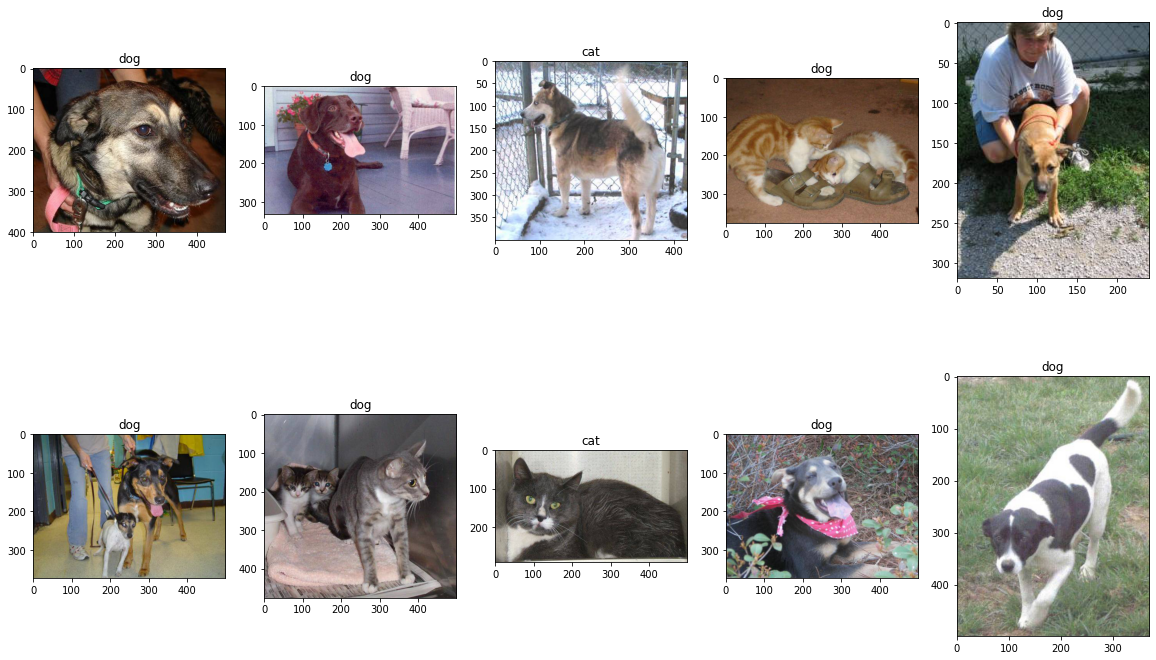

In [154]:
import random

id_list = []
class_ = {0: "cat", 1:"dog"}

fig, axes = plt.subplots(2, 5, figsize=(20,12), facecolor="w") # 第一个数：行 第二个数：列 figsize:宽和高 facecolor:背景颜色
    # 返回一个 fig：背景图  axes:坐标轴和画的图

"""   代码测试
print("axes:{}".format(axes))
print()
print("axes.ravel():".format(axes.ravel()))
print(axes.ravel())
"""

for ax in axes.ravel(): # axes.rabel()将多维数组转化为一维  有几组数据就弄几个照片 trip
    
    i = random.choice(submission["id"].values) # 索引  random.choice:随机挑选一个数
    print(i)
    label = submission.loc[submission["id"] == i, "label"].values[0]  # 按照索引提取行数据 第二个参数规定列的名称 pandas数据类型
    print(label)
    if label > 0.5:
        label = 1
    else:
        label = 0
    
    img_path = os.path.join(test_dir, "{}.jpg".format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)